In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import spacepy.toolbox as tb
import spacepy.plot as splot
import verify
np.random.seed(24601)
%matplotlib inline

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


To estimate how many ensemble members we need to estimate the prediction interval with a reasonable degree of confidence, so we simulate the problem using samples drawn from a parent distribution. We begin with a normal distribution of ($\mu$=-20, $\sigma$=4) to approximate one possible distribution of ensemble members in Dst at one time. We will also use a bounded distribution as well as a skewed distribution, since we don't yet know what the distribution of ensemble members will look like.

Gaussian: W95 = 9.799819922700268
Tukey-Lambda: W95 = 11.02955282588667
Gumbel-L: W95 = 12.453924997293534


/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


(0, 0.2)

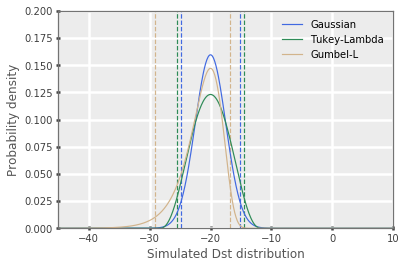

In [2]:
nmean, stddev, shape = -20, 2.5, 0.3
dist_dict = {'Gaussian': scipy.stats.norm(loc=nmean, scale=stddev),
             'Tukey-Lambda': scipy.stats.tukeylambda(shape, loc=nmean, scale=stddev),
             'Gumbel-L': scipy.stats.gumbel_l(loc=nmean, scale=stddev)}
col_dict = {'Gaussian': 'royalblue',
            'Tukey-Lambda': 'seagreen',
            'Gumbel-L': 'tan'}
xarr = np.arange(-50,50,0.1)
for distname in dist_dict:
    dist = dist_dict[distname]
    col = col_dict[distname]
    plt.plot(xarr, dist.pdf(xarr), color=col, label=distname)
    #Central 95% lies between...
    n025, n975 = dist.interval(0.95)
    print('{}: W95 = {}'.format(distname, n975-n025))
    for xval in [n025, n975]:
        plt.vlines(xval, 0, 1, linestyles='dashed', colors=col)
plt.legend()
plt.xlim([-45,10])
plt.xlabel('Simulated Dst distribution')
plt.ylabel('Probability density')
plt.ylim([0, 0.2])

## Testing the effect of number of samples

As we intend to use the fitted KDE to estimate the 95% prediction interval, we need to assess the uncertainty in determining a known percentile of the distribution given the number of samples. In our use case, the number of samples is the number of ensemble members. So we now sample our normal distribution 

In [3]:
def bwscott1d(data, scale=1):
    npts = len(data)
    bw = npts**(-1.0/5)
    return bw*scale

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5,0.98,'Gaussian Parent')

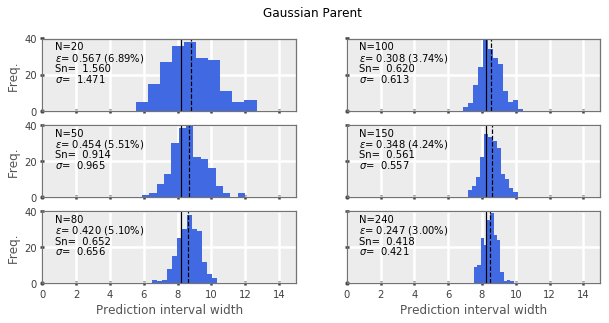

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(10,4.5))
axes = axes.T.ravel()
func025 = lambda x: kde.integrate_box_1d(-400, x)-0.05#025
func975 = lambda x: kde.integrate_box_1d(-400, x)-0.95#975

n025, n975 = dist_dict['Gaussian'].interval(0.9)
nwidth = n975-n025
for idx, npt in enumerate([20, 50, 80, 100, 150, 240]):
    lowbound, highbound, width = [], [], []
    for it in range(200):
        data = dist_dict['Gaussian'].rvs(size=npt)
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data, scale=0.8))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    binw, nbins = tb.binHisto(width)
    axes[idx].hist(width, bins=int(nbins))
    axes[idx].text(0.05, 0.85, 'N={}'.format(npt), transform=axes[idx].transAxes)
    axes[idx].set_xlim([0, 6*stddev])
    ylim = axes[idx].get_ylim()[1]
    axes[idx].vlines(nwidth, 0, ylim)
    axes[idx].vlines(np.mean(width), 0, ylim, linestyles='dashed')
    axes[idx].text(0.05, 0.7, '$\epsilon$={:6.3f} ({:4.2f}%)'.format(np.abs(nwidth-np.mean(width)), 100*np.abs(nwidth-np.mean(width))/nwidth), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.55, 'Sn={:7.3f}'.format(verify.Sn(width)), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.4, '$\sigma$={:7.3f}'.format(np.std(width)), transform=axes[idx].transAxes)
    axes[idx].set_ylim([0, ylim])
    if idx<=2: axes[idx].set_ylabel('Freq.')
    if idx==2 or idx==5: axes[idx].set_xlabel('Prediction interval width')
plt.suptitle('Gaussian Parent')

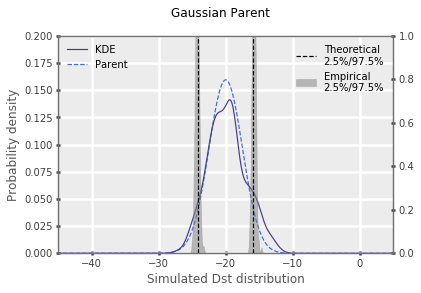

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.grid(False)
for idx, xval in enumerate(dist_dict['Gaussian'].interval(0.9)):
    if idx==0:
        ax2.vlines(xval, 0, 1, linestyles='dashed', colors='black', label='Theoretical\n2.5%/97.5%')
    else:
        ax2.vlines(xval, 0, 1, linestyles='dashed', colors='black')
pkde = scipy.stats.gaussian_kde(lowbound, bw_method=bwscott1d(data, scale=0.8))
ax2.fill_between(xarr,pkde.pdf(xarr), color='grey', alpha=0.5, label='Empirical\n2.5%/97.5%')
pkde = scipy.stats.gaussian_kde(highbound, bw_method=bwscott1d(data, scale=0.8))
ax2.fill_between(xarr,pkde.pdf(xarr), color='grey', alpha=0.5)
ax2.set_ylim([0,1])
ax.plot(xarr, kde.pdf(xarr), color='darkslateblue', label='KDE', zorder=99)
ax.plot(xarr, dist_dict['Gaussian'].pdf(xarr), color='royalblue', linestyle='dashed', label='Parent', zorder=91)
ax.set_xlim([-45,5])
ax.set_xlabel('Simulated Dst distribution')
ax.set_ylabel('Probability density')
ax.set_ylim([0,0.2])
ax.legend(loc='upper left')
plt.suptitle('Gaussian Parent')
ax2.legend(loc='upper right')

## Now to repeat with different distributions
We'll use a bounded symmetric unimodal distribution, a bounded asymmetric unimodal distribution and a bimodal distribution.

First, the bounded symmetric unimodel distribution: the Tukey-Lambda, with a shape parameter ($\lambda$) of 0.3. The support for this distribution is [-1/$\lambda$, 1/$\lambda$]

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5,0.98,'Tukey-Lambda Parent')

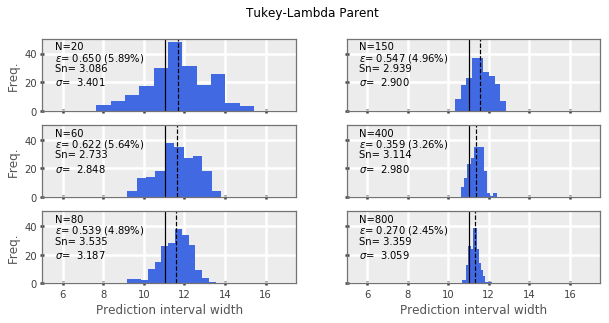

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(10,4.5))
axes = axes.T.ravel()
func025 = lambda x: kde.integrate_box_1d(-400, x)-0.025
func975 = lambda x: kde.integrate_box_1d(-400, x)-0.975

n025, n975 = dist_dict['Tukey-Lambda'].interval(0.95)
nwidth = n975-n025
for idx, npt in enumerate([20, 60, 80, 150, 400, 800]):
    lowbound, highbound, width, std = [], [], [], []
    for it in range(200):
        data = dist_dict['Tukey-Lambda'].rvs(size=npt)
        std.append(data.std())
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data, scale=0.8))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    binw, nbins = tb.binHisto(width)
    axes[idx].hist(width, bins=int(nbins))
    axes[idx].text(0.05, 0.85, 'N={}'.format(npt), transform=axes[idx].transAxes)
    axes[idx].set_xlim([5, 7*stddev])
    ylim = axes[idx].get_ylim()[1]
    axes[idx].vlines(nwidth, 0, ylim)
    axes[idx].vlines(np.mean(width), 0, ylim, linestyles='dashed')
    axes[idx].text(0.05, 0.7, '$\epsilon$={:6.3f} ({:4.2f}%)'.format(np.abs(nwidth-np.mean(width)), 100*np.abs(nwidth-np.mean(width))/nwidth), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.55, 'Sn={:6.3f}'.format(verify.Sn(data)), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.35, '$\sigma$={:7.3f}'.format(np.std(data)), transform=axes[idx].transAxes)
    axes[idx].set_ylim([0, ylim])
    if idx<=2: axes[idx].set_ylabel('Freq.')
    if idx==2 or idx==5: axes[idx].set_xlabel('Prediction interval width')
plt.suptitle('Tukey-Lambda Parent')

(array([  2.,  12.,  23.,  36.,  48.,  33.,  25.,  14.,   6.,   1.]),
 array([ 5.5108163 ,  5.58314028,  5.65546426,  5.72778824,  5.80011222,
         5.8724362 ,  5.94476018,  6.01708416,  6.08940814,  6.16173212,
         6.2340561 ]),
 <a list of 10 Patch objects>)

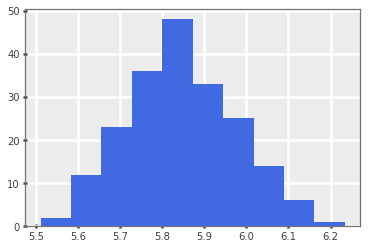

In [8]:
plt.hist(2*np.array(std))

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


(0, 0.12)

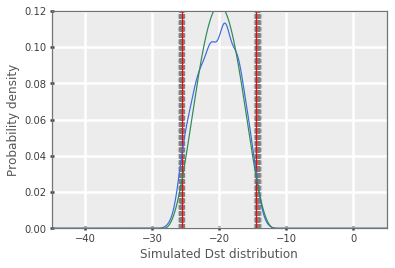

In [9]:
plt.plot(xarr, kde.pdf(xarr), label='KDE')
plt.plot(xarr, dist_dict['Tukey-Lambda'].pdf(xarr), label='Parent')
plt.xlim([-45,5])
plt.xlabel('Simulated Dst distribution')
plt.ylabel('Probability density')
for xval in [lowbound, highbound]:
    plt.vlines(xval, 0, 1, linestyles='dashed', colors='grey', alpha=0.3)
for xval in dist_dict['Tukey-Lambda'].interval(0.95):
    plt.vlines(xval, 0, 1, linestyles='solid', colors='r')
plt.ylim([0,0.12])

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5,0.98,'Gumbel-L Parent')

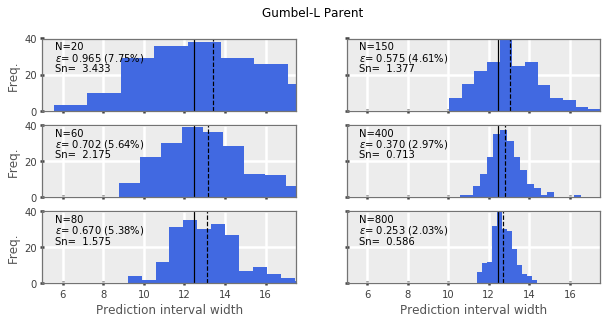

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(10,4.5))
axes = axes.T.ravel()
func025 = lambda x: kde.integrate_box_1d(-400, x)-0.025
func975 = lambda x: kde.integrate_box_1d(-400, x)-0.975

n025, n975 = dist_dict['Gumbel-L'].interval(0.95)
nwidth = n975-n025
for idx, npt in enumerate([20, 60, 80, 150, 400, 800]):
    lowbound, highbound, width, std = [], [], [], []
    for it in range(200):
        data = dist_dict['Gumbel-L'].rvs(size=npt)
        std.append(data.std())
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data, scale=0.75))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    binw, nbins = tb.binHisto(width)
    axes[idx].hist(width, bins=int(nbins))
    axes[idx].text(0.05, 0.85, 'N={}'.format(npt), transform=axes[idx].transAxes)
    axes[idx].set_xlim([5, 7*stddev])
    ylim = axes[idx].get_ylim()[1]
    axes[idx].vlines(nwidth, 0, ylim)
    axes[idx].vlines(np.mean(width), 0, ylim, linestyles='dashed')
    axes[idx].text(0.05, 0.7, '$\epsilon$={:6.3f} ({:4.2f}%)'.format(np.abs(nwidth-np.mean(width)), 100*np.abs(nwidth-np.mean(width))/nwidth), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.55, 'Sn={:7.3f}'.format(verify.Sn(width)), transform=axes[idx].transAxes)
    axes[idx].set_ylim([0, ylim])
    if idx<=2: axes[idx].set_ylabel('Freq.')
    if idx==2 or idx==5: axes[idx].set_xlabel('Prediction interval width')
plt.suptitle('Gumbel-L Parent')

(array([  2.,   9.,  13.,  27.,  35.,  43.,  35.,  19.,   8.,   9.]),
 array([  8.6603665 ,   8.83477544,   9.00918439,   9.18359334,
          9.35800228,   9.53241123,   9.70682018,   9.88122912,
         10.05563807,  10.23004701,  10.40445596]),
 <a list of 10 Patch objects>)

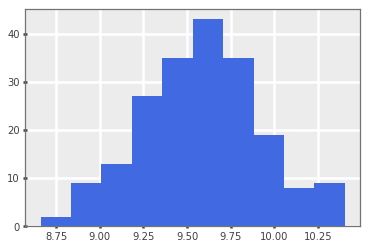

In [11]:
plt.hist(3*np.array(std))

(0, 0.12)

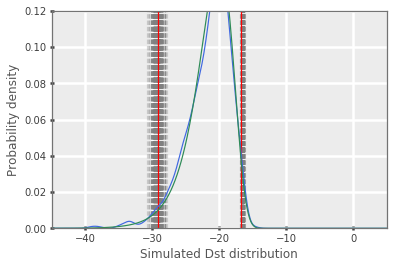

In [12]:
plt.plot(xarr, kde.pdf(xarr), label='KDE')
plt.plot(xarr, dist_dict['Gumbel-L'].pdf(xarr), label='Parent')
plt.xlim([-45,5])
plt.xlabel('Simulated Dst distribution')
plt.ylabel('Probability density')
for xval in [lowbound, highbound]:
    plt.vlines(xval, 0, 1, linestyles='dashed', colors='grey', alpha=0.3)
for xval in dist_dict['Gumbel-L'].interval(0.95):
    plt.vlines(xval, 0, 1, linestyles='solid', colors='r')
plt.ylim([0,0.12])

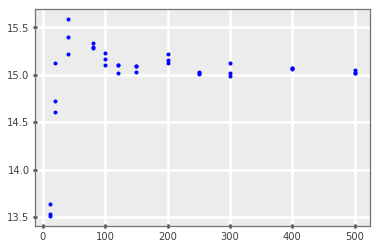

In [30]:
meanwidth = []
vals = [12,20,40,80,100,120,150,200,250,300,400,500]*3
for idx, npt in enumerate(vals):
    lowbound, highbound, width = [], [], []
    for it in range(400):
        data = scipy.stats.gumbel_l.rvs(loc=nmean, scale=stddev, size=npt)
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    meanwidth.append(np.mean(width))
plt.plot(vals, meanwidth, 'b.')